In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_dir = "/content/drive/MyDrive/Datasets"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter
from sklearn.model_selection import KFold


In [ ]:
import os

dataset_dir = os.path.join(root_dir, 'PCB_DATASET')

for root, dirs, files in os.walk(dataset_dir):
    for name in dirs:
        print(name)  # Print only the folder names


Annotations
PCB_USED
images
rotation
images_resized
output
ImageSets
.ipynb_checkpoints
final_annotations
Missing_hole
Mouse_bite
Open_circuit
Short
Spur
Spurious_copper
Missing_hole
Mouse_bite
Open_circuit
Short
Spur
Spurious_copper
Missing_hole_rotation
Mouse_bite_rotation
Open_circuit_rotation
Short_rotation
Spur_rotation
Spurious_copper_rotation
Main
Missing_hole
Mouse_bite
Open_circuit
Short
Spur
Spurious_copper


In [ ]:
# Clone Detectron2
!git clone https://github.com/facebookresearch/detectron2.git

# Change directory and install
!pip install -e detectron2

Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 15837 (delta 30), reused 12 (delta 12), pack-reused 15771 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 20.17 MiB/s, done.
Resolving deltas: 100% (11532/11532), done.
Obtaining file:///content/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.1 MB/s eta 0:00:00
  C

In [ ]:
import os
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.file_io import PathManager
import xml.etree.ElementTree as ET
from detectron2.structures import BoxMode

# Define dataset details
dataset_name = "pcb_train"
voc_root = "/content/drive/MyDrive/Datasets/PCB_DATASET"
split = "train"
year = "2007"

# Paths
annotations_root = os.path.join(voc_root, "final_annotations")
image_set_dir = os.path.join(voc_root, "ImageSets", "Main", "train.txt")

# Remove old registration if it exists
if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)

def get_subfolder(image_name):
    keywords = {
        "missing": "Missing_hole",
        "mouse": "Mouse_bite",
        "open": "Open_circuit",
        "short": "Short",
        "spur": "Spur",
        "spurious": "Spurious_copper",
    }
    for key, value in keywords.items():
        if key in image_name.lower().split("_"):
            return value
    return None  # Return None if no match is found

def load_pcb_annotations(root1, image_set_file):
    dataset_dicts = []

    with open(image_set_file, "r") as f:
        image_ids = [line.strip() for line in f]

    for image_id in image_ids:
        subfolder = get_subfolder(image_id + ".jpg")
        if not subfolder:
            print(f"⚠️ No matching subfolder found for {image_id}")
            continue

        anno_file = os.path.join(root1, subfolder, image_id + ".xml")
        jpeg_file = os.path.join(voc_root, "images_resized", image_id + ".jpg")

        if not os.path.exists(anno_file):
            print(f"⚠️ Annotation file missing: {anno_file}")
            continue

        with PathManager.open(anno_file) as f:
            tree = ET.parse(f)

        r = {
            "file_name": jpeg_file,
            "image_id": image_id,
            "height": int(tree.find("size").find("height").text),
            "width": int(tree.find("size").find("width").text),
            "annotations": [],
        }

        for obj in tree.findall("object"):
            cls = obj.find("name").text.strip().replace(" ", "_").capitalize()
            bbox = obj.find("bndbox")
            bbox = [int(bbox.find(x).text) - 1 for x in ["xmin", "ymin", "xmax", "ymax"]]

            ann = {
                "category_id": MetadataCatalog.get(dataset_name).thing_classes.index(cls),
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "iscrowd": 0,
            }
            r["annotations"].append(ann)

        dataset_dicts.append(r)

    return dataset_dicts

# Register dataset
DatasetCatalog.register(dataset_name, lambda: load_pcb_annotations(annotations_root, image_set_dir))

# Define metadata
MetadataCatalog.get(dataset_name).set(
    thing_classes=["Missing_hole", "Mouse_bite", "Open_circuit", "Short", "Spur", "Spurious_copper"],
    dirname=voc_root,
    year=year,
    split=split
)

print(f"✅ Successfully registered dataset '{dataset_name}'")


✅ Successfully registered dataset 'pcb_train'


In [ ]:
from detectron2.data import DatasetCatalog

# Load dataset
dataset_dicts = DatasetCatalog.get("pcb_train")

# Print some details
print(f"✅ Loaded {len(dataset_dicts)} images from dataset!")

# Print a sample
print(dataset_dicts[:2])  # Show first 2 samples


KeyboardInterrupt: 

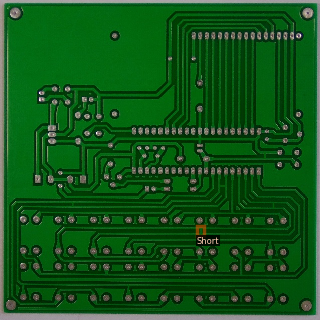

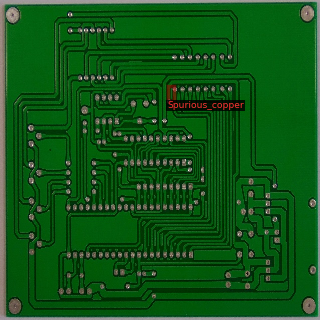

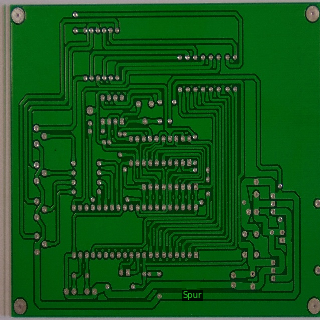

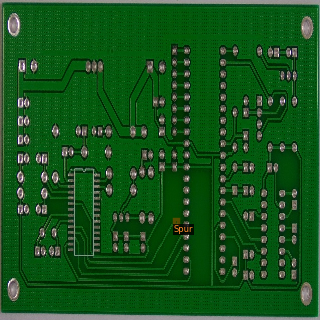

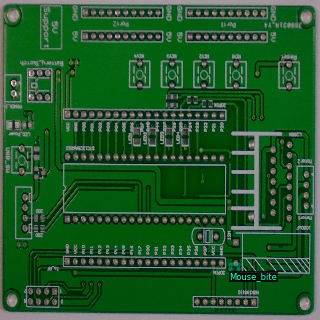

In [ ]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from google.colab.patches import cv2_imshow

# Load metadata
metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

# Visualize a few samples
for d in random.sample(dataset_dicts, min(5, len(dataset_dicts))):
    img = cv2.imread(d["file_name"])
    if img is None:
        print(f"⚠️ Could not read image: {d['file_name']}")
        continue

    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (dataset_name,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.STEPS = [1000, 2000]
cfg.SOLVER.GAMMA = 0.5
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
cfg.OUTPUT_DIR = "/content/drive/MyDrive/Datasets/PCB_DATASET/output"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[03/24 15:39:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
R-50.pkl: 102MB [00:00, 190MB/s]                            


[03/24 15:43:00 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[03/24 15:43:00 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54


backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[03/24 15:43:00 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/24 15:43:09 d2.utils.events]:  eta: 0:14:42  iter: 19  total_loss: 3.151  loss_cls: 2.44  loss_box_reg: 0.001272  loss_rpn_cls: 0.6555  loss_rpn_loc: 0.06305    time: 0.2865  last_time: 0.2191  data_time: 0.0385  last_data_time: 0.0047   lr: 2.6203e-06  max_mem: 1731M
[03/24 15:43:20 d2.utils.events]:  eta: 0:13:46  iter: 39  total_loss: 2.458  loss_cls: 1.665  loss_box_reg: 0.001072  loss_rpn_cls: 0.6529  loss_rpn_loc: 0.07274    time: 0.2817  last_time: 0.2488  data_time: 0.0059  last_data_time: 0.0044   lr: 5.1152e-06  max_mem: 1734M
[03/24 15:43:26 d2.utils.events]:  eta: 0:13:43  iter: 59  total_loss: 1.37  loss_cls: 0.6393  loss_box_reg: 0.001045  loss_rpn_cls: 0.6457  loss_rpn_loc: 0.06261    time: 0.2838  last_time: 0.3065  data_time: 0.0059  last_data_time: 0.0103   lr: 7.6102e-06  max_mem: 1734M
[03/24 15:43:32 d2.utils.events]:  eta: 0:13:57  iter: 79  total_loss: 1.025  loss_cls: 0.2962  loss_box_reg: 0.0009678  loss_rpn_cls: 0.6354  loss_rpn_loc: 0.06392    time: 0.286

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Create an evaluator using COCO metrics
evaluator = COCOEvaluator(dataset_name, output_dir="./output")
val_loader = build_detection_test_loader(cfg, dataset_name)

# Run evaluation
print("Running Evaluation...")
inference_on_dataset(trainer.model, val_loader, evaluator)


[03/24 15:58:14 d2.evaluation.coco_evaluation]: Trying to convert 'pcb_train' to COCO format ...
[03/24 15:58:14 d2.data.datasets.coco]: Converting annotations of dataset 'pcb_train' to COCO format ...)
[03/24 15:58:17 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/24 15:58:17 d2.data.datasets.coco]: Conversion finished, #images: 693, #annotations: 693
[03/24 15:58:17 d2.data.datasets.coco]: Caching COCO format annotations at './output/pcb_train_coco_format.json' ...
[03/24 15:58:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/24 15:58:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/24 15:58:19 d2.data.common]: Serializing 693 elements to byte tensors and concatenating them all ...
[03/24 15:58:19 d2.data.common]: Serialized dataset takes 0.19 MiB
Running Evaluation...
[03/24 15:58:1

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[03/24 15:58:20 d2.evaluation.evaluator]: Inference done 11/693. Dataloading: 0.0028 s/iter. Inference: 0.0770 s/iter. Eval: 0.0003 s/iter. Total: 0.0801 s/iter. ETA=0:00:54
[03/24 15:58:25 d2.evaluation.evaluator]: Inference done 73/693. Dataloading: 0.0028 s/iter. Inference: 0.0783 s/iter. Eval: 0.0003 s/iter. Total: 0.0815 s/iter. ETA=0:00:50
[03/24 15:58:30 d2.evaluation.evaluator]: Inference done 133/693. Dataloading: 0.0030 s/iter. Inference: 0.0790 s/iter. Eval: 0.0003 s/iter. Total: 0.0824 s/iter. ETA=0:00:46
[03/24 15:58:35 d2.evaluation.evaluator]: Inference done 196/693. Dataloading: 0.0025 s/iter. Inference: 0.0788 s/iter. Eval: 0.0003 s/iter. Total: 0.0817 s/iter. ETA=0:00:40
[03/24 15:58:40 d2.evaluation.evaluator]: Inference done 256/693. Dataloading: 0.0026 s/iter. Inference: 0.0795 s/iter. Eval: 0.0003 s/iter. Total: 0.0824 s/iter. ETA=0:00:36
[03/24 15:58:45 d2.evaluation.evaluator]: Inference done 317/693. Dataloading: 0.0025 s/iter. Inference: 0.0795 s/iter. Eval: 0

OrderedDict([('bbox',
              {'AP': 0.38225707893804045,
               'AP50': 1.2098252980381357,
               'AP75': 0.07665094368005633,
               'APs': 0.4565724670399121,
               'APm': 0.0,
               'APl': nan,
               'AP-Missing_hole': 2.025841683796626,
               'AP-Mouse_bite': 0.039609686489741634,
               'AP-Open_circuit': 0.17657897783251972,
               'AP-Short': 0.013125158669713127,
               'AP-Spur': 0.0278390370466631,
               'AP-Spurious_copper': 0.0105479297929793})])

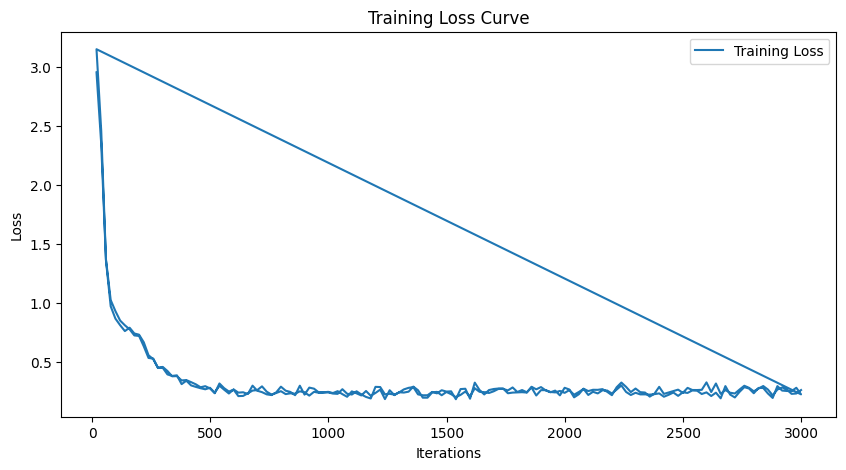

In [ ]:
import json
import matplotlib.pyplot as plt

# Path to the metrics.json
metrics_file = "/content/drive/MyDrive/Datasets/PCB_DATASET/output/metrics.json"

# Read the metrics data
iterations, losses = [], []
with open(metrics_file, 'r') as f:
    for line in f:
        data = json.loads(line)
        if 'total_loss' in data:
            iterations.append(data['iteration'])
            losses.append(data['total_loss'])

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(iterations, losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

test_csv_path = "/path_to_test_annotations.csv"
test_image_dir = "/path_to_test_images"

def load_test_data():
    df = pd.read_csv(test_csv_path)
    dataset_dicts = []

    for _, row in df.iterrows():
        record = {
            "file_name": os.path.join(test_image_dir, row["filename"]),
            "image_id": row["filename"],
            "height": 640,
            "width": 640,
            "annotations": [{
                "bbox": [row["xmin"], row["ymin"], row["xmax"], row["ymax"]],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": row["class"],
                "iscrowd": 0,
            }]
        }
        dataset_dicts.append(record)

    return dataset_dicts

# Register the test set
dataset_name_test = "pcb_test"
if dataset_name_test in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name_test)
    MetadataCatalog.remove(dataset_name_test)

DatasetCatalog.register(dataset_name_test, load_test_data)
MetadataCatalog.get(dataset_name_test).set(thing_classes=["Missing_hole", "Mouse_bite", "Open_circuit", "Short", "Spur", "Spurious_copper"])


namespace(name='pcb_test',
          thing_classes=['Missing_hole',
                         'Mouse_bite',
                         'Open_circuit',
                         'Short',
                         'Spur',
                         'Spurious_copper'])

In [ ]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TEST = (dataset_name_test,)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Adjust as needed
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Path to trained model

predictor = DefaultPredictor(cfg)


[03/24 06:00:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator(dataset_name_test, cfg, False, output_dir="/content/drive/MyDrive/Datasets/PCB_DATASET/output")
val_loader = build_detection_test_loader(cfg, dataset_name_test)
inference_on_dataset(predictor.model, val_loader, evaluator)


WARNING [03/24 06:02:16 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


FileNotFoundError: [Errno 2] No such file or directory: './output/pcb_test_coco_format.json'